In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PreProccesing


In [33]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
minmax = MinMaxScaler()
df = pd.read_csv("/content/drive/MyDrive/S104/rootColab/features.csv")

features = ['ampenv', 'rmse', 'zcr', 'spectral_centroid', 'mfcc_0', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'lpc_0', 'lpc_1', 'lpc_2',
       'lpc_3', 'lpc_4', 'lpc_5']
targets = ['is_violin', 'is_voice', 'is_mridangam']
df_features = df[features]
#Standarize and Normalize data.
standarized = pd.DataFrame(scaler.fit_transform(df_features),columns=features)
normalized =  pd.DataFrame(minmax.fit_transform(df_features),columns=features)
normalized.fillna(normalized.mean(), inplace=True)
#Create 2 DF (Uniques Instruments, All together instruments).
normalized["targets"]=df[targets[0]]+2*df[targets[1]]+4*df[targets[2]]
for t in targets:
  normalized[str(t)]=df[t]
uniques_normalized = normalized[normalized["targets"].isin([1,2,4])]
only_violin = uniques_normalized[uniques_normalized["targets"].isin([1])]
only_voice = uniques_normalized[uniques_normalized["targets"].isin([2])]
only_mridangam = uniques_normalized[uniques_normalized["targets"].isin([4])]
has_violin = normalized[normalized["is_violin"]==1]
has_voice = normalized[normalized["is_voice"]==1]
has_mridangam = normalized[normalized["is_mridangam"]==1]
#Equal the number of samples for each instrument.
mcm_length_has = min(has_violin.shape[0],has_voice.shape[0],has_mridangam.shape[0])
final_df = pd.concat([has_violin.sample(mcm_length_has,random_state=42),has_voice.sample(mcm_length_has,random_state=42),has_mridangam.sample(mcm_length_has,random_state=42)])
mcm_length_only = min(only_violin.shape[0],only_voice.shape[0],only_mridangam.shape[0])
final_df_uniques = pd.concat([only_violin.sample(mcm_length_only,random_state=42),only_voice.sample(mcm_length_only,random_state=42),only_mridangam.sample(mcm_length_only,random_state=42)])
mapping_uniques = {1: "violin", 2: "voice", 4: "mridangam"}
mapping = {1: "violin", 2: "voice", 4: "mridangam",3:"violin+voice",5:"violin+mridangam",6:"voice+mridangam",7:"violin+voice+mridangam"}


PCA 1-2

In [11]:
import plotly.express as px
from sklearn.decomposition import PCA

X = final_df_uniques[features]

pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=final_df_uniques['targets'],labels={'0': 'PCA 1', '1': 'PCA 2'}, width=2000, height=1000)
fig.show()


PCA 1-2-3

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(final_df_uniques[features])

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=final_df_uniques['targets'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PCA 1', '1': 'PCA 2', '2': 'PCA 3'},
    width=2000, height=1000
)
fig.update_traces(marker=dict(size=3))
fig.show()

<ipython-input-18-cd27e7e2d590>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-18-cd27e7e2d590>:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-18-cd27e7e2d590>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



{'whiskers': [<matplotlib.lines.Line2D at 0x7c32d76badd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7c32d76f54b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c32d76bbe80>,
 'medians': [<matplotlib.lines.Line2D at 0x7c32cbd44490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7c32cbd44730>,
 'means': []}

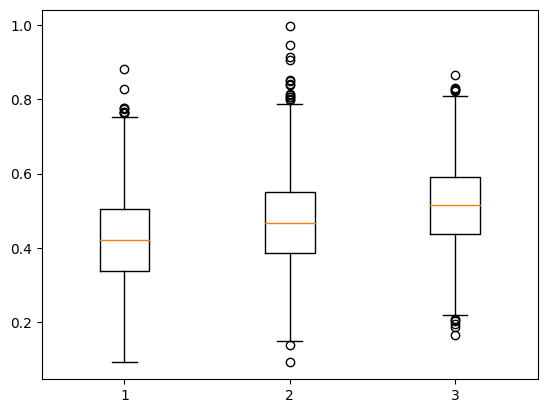

In [ ]:
import numpy as np
feature = 'mfcc_5'
vals0 = final_df_uniques[uniques_normalized['targets']==1][feature].values
vals1 = final_df_uniques[uniques_normalized['targets']==2][feature].values
vals2 = final_df_uniques[uniques_normalized['targets']==4][feature].values

plt.boxplot(np.array(list(zip(vals0,vals1,vals2))))

**Modeling**

Non Uniques

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns


df_train, df_test= train_test_split(final_df, test_size=0.2, random_state=42)

In [37]:
features = ['ampenv', 'rmse', 'zcr', 'spectral_centroid', 'mfcc_0', 'mfcc_1',
       'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'lpc_0', 'lpc_1', 'lpc_2',
       'lpc_3', 'lpc_4', 'lpc_5']

- Violin

In [38]:
target = "is_violin"
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]
clf_violin = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_violin.fit(X_train, y_train)
y_pred = clf_violin.predict(X_test)
f1 = f1_score(y_pred, y_test)
print(target,f1)

is_violin 0.602884832093757


- Voice

In [39]:
target = "is_voice"
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]
clf_voice = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_voice.fit(X_train, y_train)
y_pred = clf_voice.predict(X_test)
f1 = f1_score(y_pred, y_test)
print(target,f1)

is_voice 0.912050116693281


- Mridangam

In [ ]:
target = "is_mridangam"
X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]
clf_mridangam = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_mridangam.fit(X_train, y_train)
y_pred = clf_mridangam.predict(X_test)
f1 = f1_score(y_pred, y_test)
print(target,f1)

is_mridangam 0.6442330006962173


- General

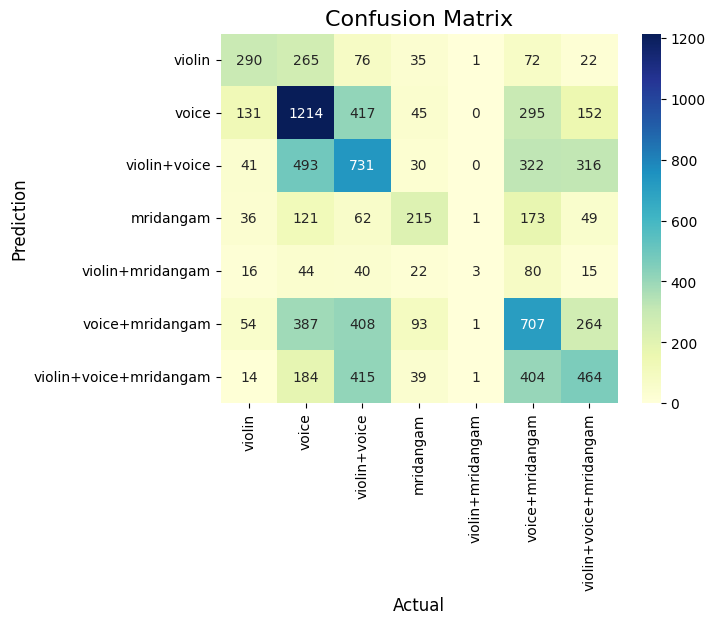

In [28]:
X_train = df_train[features]
y_train = df_train["targets"]
X_test = df_test[features]
y_test = df_test["targets"]
clf_mridangam = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_mridangam.fit(X_train, y_train)
y_pred = clf_mridangam.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
targets_matrix =['violin', 'voice', 'violin+voice','mridangam', 'violin+mridangam', 'voice+mridangam', 'violin+voice+mridangam']
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=targets_matrix, yticklabels=targets_matrix)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

Uniques

In [22]:
df_train_uniq, df_test_uniq= train_test_split(final_df_uniques, test_size=0.33, random_state=42)

- Violin

In [ ]:
target = "is_violin"
X_train = df_train_uniq[features]
y_train = df_train_uniq[target]
X_test = df_test_uniq[features]
y_test = df_test_uniq[target]
clf_violin_uniq = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_violin_uniq.fit(X_train, y_train)
y_pred = clf_violin_uniq.predict(X_test)
f1 = f1_score(y_pred, y_test)
print(target,f1)

is_violin 0.595607927155865


- Voice

In [ ]:
target = "is_voice"
X_train = df_train_uniq[features]
y_train = df_train_uniq[target]
X_test = df_test_uniq[features]
y_test = df_test_uniq[target]
clf_voice_uniq = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_voice_uniq.fit(X_train, y_train)
y_pred = clf_voice_uniq.predict(X_test)
f1 = f1_score(y_pred, y_test)
print(target,f1)

is_voice 0.6074866310160427


- Mridangam

In [40]:
target = "is_mridangam"
X_train = df_train_uniq[features]
y_train = df_train_uniq[target]
X_test = df_test_uniq[features]
y_test = df_test_uniq[target]
clf_mridangam_uniq = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_mridangam_uniq.fit(X_train, y_train)
y_pred = clf_mridangam_uniq.predict(X_test)
f1 = f1_score(y_pred, y_test)
print(target,f1)

is_mridangam 0.6919620569146281


- General

[4. 1. 2. ... 4. 2. 4.]


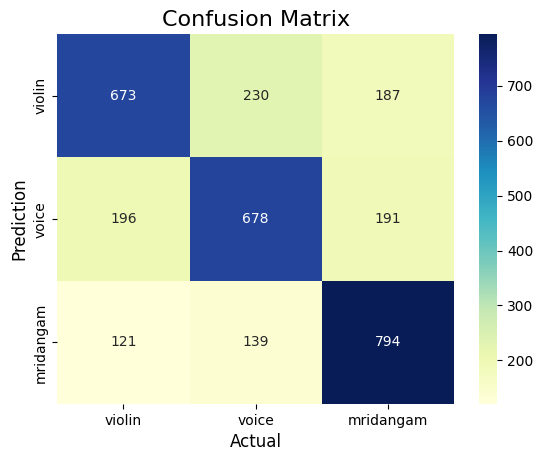

In [31]:
X_train = df_train_uniq[features]
y_train = df_train_uniq["targets"]
X_test = df_test_uniq[features]
y_test = df_test_uniq["targets"]
clf_mridangam = GradientBoostingClassifier(learning_rate=0.1,max_depth=5, min_samples_leaf=0.1, n_estimators=200)
clf_mridangam.fit(X_train, y_train)
y_pred = clf_mridangam.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
targets_matrix_uniq =['violin', 'voice', 'mridangam']
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=targets_matrix_uniq, yticklabels=targets_matrix_uniq)
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

**HyperParameter Tunning**

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
    "min_samples_leaf": np.linspace(0.1, 0.5, 4),
    "max_depth":[3, 5, 8, 10],
    "n_estimators":[10, 50, 100]
}



Non Uniques

In [ ]:
# df_train, df_test= train_test_split(final_df, test_size=0.33, random_state=42)

- Violin

In [ ]:
# target = "is_violin"
# X_train = df_train[features]
# y_train = df_train[target]
# clf_violin = GradientBoostingClassifier()
# gs_violin = GridSearchCV(clf_violin, param_grid=parameters, scoring='f1', cv=5)
# gs_violin.fit(X_train, y_train)
# best_violin = gs_violin.best_estimator_
# print(gs_violin.best_params_)